# DATA601

Joshua Black

## Exploring nb2 subset with text analytics

In [2]:
#Imports
from __future__ import print_function

import sys
import os
import glob
import re
import logging
from random import sample

import pandas as pd
import numpy as np
import networkx as nx

from gensim import corpora
from gensim.models import LdaMulticore, TfidfModel
from gensim.matutils import corpus2csc

from nltk.text import Text
from nltk.tokenize import RegexpTokenizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import stopwords, words

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from jupyter_dash import JupyterDash
import dash_cytoscape as cyto
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

import NL_helpers
import NL_topicmodels # Will need to generate BOW using function in topic models.

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

TOKENIZER = RegexpTokenizer(r"[A-Za-z']+")
STOPWORDS = set(stopwords.words('english'))
WORDS = set(words.words()) 

In [ ]:
# Run cell to reload NL_helpers and NL_topicmodels if they have been changed.
from importlib import reload
reload(NL_helpers)
reload(NL_topicmodels)

### Loading Dataset

I have already generated a dataset containing all articles with the regex search term 'philoso*' run on the NL library. I load it as follows:

**Note, error:** the step at which I apply the search is before the text has been converted to lower case. The results of the re search are case sensitive. I had intended to include, e.g. 'Philosophy' as well. I don't expect that this will cause too many problems. 

In [3]:
philoso_df = pd.read_pickle('pickles/nb2_philoso_df_v2.tar.gz')

In [4]:
philoso_df['Tokenised'] = philoso_df['Text'].apply(
    lambda x: TOKENIZER.tokenize(NL_helpers.blocks2string(x).lower())
)

In [ ]:
# Duplicates ought to be removed from 'subset' corpus, but have already been removed from full 'philoso*' corpus.
# philoso_df = philoso_df[~philoso_df.astype(str).duplicated()]

In [5]:
# Counts by newspaper
philoso_df.index.map(lambda x: x[0:x.find('_')]).value_counts()

ODT        2867
ESD        2733
OW         2699
AS         2231
LT         2173
CHP        1881
BH         1594
NZTIM      1391
TC          986
NEM         849
HBH         831
DSC         763
OAM         710
NOT         661
MEX         583
WH          570
WSTAR       549
WC          545
DTN         527
WT          521
LWM         512
CROMARG     455
WCT         436
ME          386
GRA         385
AG          361
WI          289
WDT         248
MIC         230
FS          209
DUNST       162
IT          155
OO          149
WAIST       139
WEST        138
LCP         135
BA          124
HBT         123
CL          112
HNS         102
MH           96
MS           92
MT           75
WOODEX       74
NA           58
KUMAT        52
HAST         49
OG           32
NZSCSG       26
OPUNT        15
HLC          14
NZCPNA        8
HBWT          8
NZGWS         7
WDA           6
MTBM          2
ALG           2
CHARG         1
dtype: int64

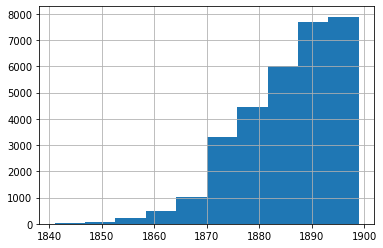

In [6]:
# Counts by year.
philoso_df.index.map(lambda x: int(x[x.find('_')+1:x.find('_')+5])).to_series().hist()

### Basic Exploration

#### Inspecting a subset of the corpus

We can look at a random subset of the corpus as follows:

In [ ]:
sample_indices = sample(list(philoso_df.index), 100)
interact(NL_helpers.html_text, index=sample_indices, dataframe=fixed(philoso_df), boldface=fixed('philoso*\\w*'))

A few notes: * (Note your random sample will be different)
 - AS_18860821_ARTICLE40: Example of argument with 'freethinker' over grouding ethics(?) in 'natural right' vs Christian approach. Interesting as lower limit in terms of OCR quality?
 - Use of 'philosophical' to mean deep, resigned, detatched.
 - 'philosophers and sceptics' vs Christians.
 - CHP_18980425_ARTICLE60: Report of what is issued at the wellington public library in 1898 - 'philosophical subjects are almost entire;y neglected'
 - Discussion of Darwinism as new philosophy.
 - Discussions of e.g. Stoicism.
 - 1893 Hosking on Miricles, listed as 'popular lecture'. CHP_18930515_ARTICLE22
 - **In general, quite a few reprints of exerpts from texts. (e.g. BH_18890222_ARTICLE33)
 - Robert Stout comes up a lot as an early political figure who is thought of as having, e.g. 'a philosophic mind'.
 - Some lecture reports coming through (e.g. AS_18800817_ARTICLE22, CHP_18690823_ARTICLE15)
 - Theosophy coming through
 - Quite a lot of extracts of fiction (one with a Hegelian character).
 - CL_18790919_ARTICLE27 - first-order philosophy - including definition of 'philosophy' in Clutha Leader.
 - CHP_18920926_ARTICLE10 - good letters to editor on 'freethought' and christianity
 

#### Concordancing

We begin by quickly looking through concordances for key words. The initial 'flat list' of tokens is taken from a random sample of 1000 items in the corpus.

In [ ]:
flat_list = []
for tokens in philoso_df['Tokenised'].sample(n=1000, random_state=1):
    for token in tokens:
        flat_list.append(token)
sample_text = Text(flat_list)
del flat_list

In [ ]:
sample_text.concordance('philosophy', width=100, lines=150)

In [ ]:
sample_text.concordance('lecture', width=100, lines=150)

In [ ]:
del sample_text

#### Collocations

Collocations shows which words have a tendency to appear together *near one another* in documents (cf. co-occurrence). The ranking of word pairs depends on the statistic chosen.

**PMI:** pointwise mutual information is a measure from information theory. Suppose we have probability distributions for each word, *x* and *y*, we might wonder how much information about p(x) is carried by p(y). If the words *x* and *y* always occur together, then *pmi* will be very high. This makes PMI a good measure of word occurence (dreadful - come back once you've reminded yourself how this works).

**Likelihood ratio:**

The code below collects all immediate bigrams for a window of size 2 and of size 5. We then filter our bigrams which do not contain 'philosophy', those which appear less than three times, and those which contain stopwords.

We again build up a flat list, but this time with the whole corpus.

In [ ]:
flat_list = []
for tokens in philoso_df['Tokenised']:
    for token in tokens:
        flat_list.append(token)
all_text = Text(flat_list)
del flat_list

##### Window size = 2

In [ ]:
philoso_filter = lambda *w: 'philosophy' not in w
stopword_filter = lambda w: w in STOPWORDS

In [ ]:
bcf = BigramCollocationFinder.from_words(all_text)

In [ ]:
bcf.apply_ngram_filter(philoso_filter)
bcf.apply_word_filter(stopword_filter)
bcf.apply_freq_filter(10)

In [ ]:
bm = BigramAssocMeasures()

In [ ]:
pmi_ws2 = bcf.nbest(bm.pmi, 50)
pmi_ws2

In [ ]:
lr_ws2 = bcf.nbest(bm.likelihood_ratio, 50)
lr_ws2

In [ ]:
pmi_not_lr = []
for collocation in pmi_ws2:
    if collocation not in lr_ws2:
        pmi_not_lr.append(collocation)
pmi_not_lr

In [ ]:
lr_not_pmi = []
for collocation in lr_ws2:
    if collocation not in pmi_ws2:
        lr_not_pmi.append(collocation)
lr_not_pmi

The differences here don't seem to make a big difference to the conclusions above. Not surprising as they are very closely related measures.

In [ ]:
del bcf
del all_text

##### Window size = 5

We can also expand the window to consider words either five spaces to the left or right of philosophy. (Window size includes stopwords)

In [ ]:
bcf_big = BigramCollocationFinder.from_words(all_text, window_size=5)

In [ ]:
bcf_big.apply_ngram_filter(philoso_filter)
bcf_big.apply_word_filter(stopword_filter)
bcf_big.apply_freq_filter(10)

In [ ]:
pmi_ws5 = bcf_big.nbest(bm.pmi, 50)
pmi_ws5

In [ ]:
lr_ws5 = bcf_big.nbest(bm.likelihood_ratio, 50)
lr_ws5

In [ ]:
pmi_not_lr_ws5 = []
for collocation in pmi_ws5:
    if collocation not in lr_ws5:
        pmi_not_lr_ws5.append(collocation)
pmi_not_lr_ws5

In [ ]:
lr_not_pmi_ws5 = []
for collocation in lr_ws5:
    if collocation not in pmi_ws5:
        lr_not_pmi_ws5.append(collocation)
lr_not_pmi_ws5

In [ ]:
len(lr_not_pmi_ws5)

In [ ]:
del bcf_big, all_text

Differences in scoring more pronounced.

#### Co-occurence

To perform document-level cooccurence analysis we will shift from NLTK to gensim. We first build a dictionary.

This dictionary is much too large for our purposes (at ~70k words). We can filter stop words and all one and two letter words from the tokenized text to see what happens.

In [7]:
philoso_df['Tokenised'] = philoso_df['Tokenised'].map(lambda x: [word for word in x if len(word)>2 and not word in STOPWORDS and word in WORDS])

In [8]:
minimum_in_docs = 50 # 10
max_prop = 0.1
dictionary = corpora.Dictionary(philoso_df['Tokenised'])
dictionary.filter_extremes(no_below=minimum_in_docs, no_above=max_prop)
dictionary.compactify()

2021-01-26 23:46:16,069 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-01-26 23:46:18,641 : INFO : adding document #10000 to Dictionary(29796 unique tokens: ['appear', 'ashamed', 'atmos', 'beautiful', 'become']...)
2021-01-26 23:46:21,330 : INFO : adding document #20000 to Dictionary(35394 unique tokens: ['appear', 'ashamed', 'atmos', 'beautiful', 'become']...)
2021-01-26 23:46:24,102 : INFO : adding document #30000 to Dictionary(38834 unique tokens: ['appear', 'ashamed', 'atmos', 'beautiful', 'become']...)
2021-01-26 23:46:24,488 : INFO : built Dictionary(39202 unique tokens: ['appear', 'ashamed', 'atmos', 'beautiful', 'become']...) from 31131 documents (total 7656141 corpus positions)
2021-01-26 23:46:24,570 : INFO : discarding 29725 tokens: [('appear', 3143), ('become', 5860), ('best', 6763), ('better', 6852), ('character', 6357), ('even', 12177), ('every', 13016), ('existence', 4658), ('far', 9655), ('feel', 3664)]...
2021-01-26 23:46:24,571 : INFO : keeping 94

In [8]:
dictionary.save(f'dictionaries/nb2_philoso_df_min{minimum_in_docs}_max{int(max_prop*100)}perc.dict')

2021-01-19 10:03:28,096 : INFO : saving Dictionary object under dictionaries/nb2_philoso_df_min50_max10perc.dict, separately None
2021-01-19 10:03:28,555 : INFO : saved dictionaries/nb2_philoso_df_min50_max10perc.dict


In [9]:
philo_corpus = NL_topicmodels.NL_corpus(philoso_df, dictionary)

In [10]:
tfidf_model = TfidfModel(philo_corpus, dictionary=philo_corpus.dictionary)

2021-01-26 23:46:38,279 : WARNING : constructor received both corpus and explicit inverse document frequencies; ignoring the corpus


In [ ]:
philo_corpus.items

In [11]:
philo_corpus.items['TF-IDF'] = tfidf_model[philo_corpus]

In [ ]:
philo_corpus.items

Changes over time? - I don't think this is helping me. Need some more non-philosophy as a background.

In [20]:
sparse = corpus2csc(philo_corpus.items['BOW'])

In [21]:
dtm = pd.DataFrame.sparse.from_spmatrix(sparse)
del sparse

In [22]:
dtm.index = philo_corpus.dictionary.values()

In [23]:
dtm

,0,1,2,3,4,5,6,7,8,9,...,31121,31122,31123,31124,31125,31126,31127,31128,31129,31130
ashamed,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
atmos,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
beautiful,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
blush,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bub,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
recognize,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
toa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
korero,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
dtm.to_pickle('pickles/dtm_nb2_v2_BOW_9kwords.tar.gz')

In [25]:
tt_df = dtm.dot(dtm.transpose())

In [26]:
tt_df.to_pickle('pickles/ttm_nb2_v2_BOW_9kwords.tar.gz')

In [27]:
tt_df

,ashamed,atmos,beautiful,blush,bub,build,callous,capable,close,confined,...,declamation,unsolved,advertiser,coo,intentional,recognize,toa,korero,roto,tana
ashamed,890.0,2.0,83.0,20.0,40.0,38.0,7.0,62.0,57.0,26.0,...,3.0,1.0,2.0,1.0,3.0,5.0,0.0,0.0,0.0,0.0
atmos,2.0,143.0,27.0,3.0,6.0,7.0,2.0,28.0,25.0,3.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
beautiful,83.0,27.0,5881.0,81.0,428.0,267.0,38.0,449.0,464.0,175.0,...,14.0,14.0,11.0,6.0,18.0,23.0,9.0,0.0,0.0,2.0
blush,20.0,3.0,81.0,503.0,16.0,25.0,4.0,36.0,29.0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
bub,40.0,6.0,428.0,16.0,4344.0,90.0,7.0,152.0,181.0,76.0,...,7.0,2.0,2.0,7.0,2.0,0.0,6.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
recognize,5.0,1.0,23.0,0.0,0.0,5.0,0.0,16.0,14.0,5.0,...,2.0,1.0,0.0,0.0,0.0,71.0,0.0,0.0,0.0,2.0
toa,0.0,0.0,9.0,2.0,6.0,3.0,0.0,4.0,9.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,74.0,93.0,86.0,78.0
korero,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93.0,5748.0,1916.0,1652.0
roto,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,86.0,1916.0,1164.0,896.0


In [ ]:
# See https://tm4ss.github.io/docs/Tutorial_5_Co-occurrence.html
def dice_coocs(term, dtm, ttm, num_coocs):
    """Return num_coocs with dice statistics given search term
    document-term matrix and term-term matrix. Return as 
    pandas series with terms as indices and significances as values..
    ttm and dtm are pandas dataframes."""
    #num_documents = len(dtm.columns)
    all_term_occurrences = dtm.sum(axis=1)
    term_occurrences = all_term_occurrences[term]
    cooccurrences = ttm.loc[term]
    dicesig = 2 * cooccurrences / (term_occurrences + all_term_occurrences)
    dicesig = dicesig.sort_values(ascending=False)[0:num_coocs]
    return dicesig

In [ ]:
dicesig = 2 * cooccurrences / (term_occurrences + all_term_occurrences)

In [ ]:
type(dicesig)

In [ ]:
dicesig.sort_values(ascending=False)[0:15]

In [ ]:
dice_coocs('philosophy', binary_dtm, tt_df, 20)

In [ ]:
NL_helpers.log_dice_coocs('infinite', dtm, tt_df, 20)

In [ ]:
philo_cooc = dice_coocs('philosophy', binary_dtm, tt_df, 10)

In [ ]:
philo_network = NL_helpers.network_dataframe(
    term='philosophy', 
    stat='ml', 
    dtm=dtm,
    ttm=tt_df,
    num_coocs=10
)

In [ ]:
philo_network_df = pd.DataFrame(data=philo_network)

In [ ]:
network = {}
for item in philo_cooc.iteritems():
    from_list = network.get('source', [])
    from_list.append('philosophy')
    network['source'] = from_list
    to_list = network.get('target', [])
    to_list.append(item[0])
    network['target'] = to_list
    weight_list = network.get('weight', [])
    weight_list.append(item[1])
    network['weight'] = weight_list
    
    item_coocs = dice_coocs(item[0], binary_dtm, tt_df, 10)
    for sub_item in item_coocs.iteritems():
        if item[0] != sub_item[0]:
            from_list = network.get('source', [])
            from_list.append(item[0])
            network['source'] = from_list
            to_list = network.get('target', [])
            to_list.append(sub_item[0])
            network['target'] = to_list
            weight_list = network.get('weight', [])
            weight_list.append(sub_item[1])
            network['weight'] = weight_list
    

In [ ]:
network_df = pd.DataFrame(data=network)

In [ ]:
network_df

In [ ]:
G = nx.convert_matrix.from_pandas_edgelist(philo_network_df, edge_attr='weight')

In [ ]:
edges = G.edges()
weights = [np.exp(G[u][v]['weight']) * 0.01 for u,v in edges]

In [ ]:
d = nx.degree(G)
sizes = [(d[node]+1) * 100 for node in G.nodes()]

In [ ]:
layout = nx.drawing.layout.spring_layout(G, k=1/np.sqrt(len(G.nodes)))

In [ ]:
len(G.nodes)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
# Visualize graph components
nx.draw_networkx_edges(G, layout, alpha=0.5, width=weights, edge_color="m")
nx.draw_networkx_nodes(G, layout, node_size=sizes, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
labels = nx.draw_networkx_labels(G, layout, font_size=11, bbox=label_options)

In [ ]:
philo_net = NL_helpers.network_dash(
    term='philosophy', 
    stat='log dice', 
    dtm=dtm,
    ttm=tt_df,
    num_coocs=25,
    sec_coocs=5
)

In [ ]:
philo_net

In [ ]:
app = JupyterDash(__name__)

philo_cytoscape = cyto.Cytoscape(
        id='philosophy-network',
        minZoom=1,
        layout={'name': 'cose'},
        style={'width': '100%', 'height': '800px'},
        elements=philo_net,
        stylesheet=[
            {
                'selector': 'edge',
                'style': {
                    'width': 'mapData(weight, 3, 6, 1, 3)',
                    'line-color': 'silver'
                }
            },
            {
                'selector': 'node',
                'style': {
                    'content': 'data(label)',
                    'width': 'mapData(size, 1, 10, 10, 20)',
                    'height': 'mapData(size, 1, 10, 10, 20)'
                }
            },
            {
                'selector': 'label',
                'style': {
                    'font-size': 6,
                    'text-valign': 'center',
                    'text-background-color': 'white',
                    'text-background-opacity': 0.6,
                    'text-background-padding': 1,
                    'text-border-color': 'black',
                    'text-border-opacity': 1,
                    'text-border-width': 0.5
                }
            }
        ]
    )

app.layout = html.Div([
    html.H2("Cooccurence Networks (BOW)"),
    html.P("Search Term:"),
    dcc.Input(
        id='search-term',
        type='text',
        value='philosophy'
    ),
    html.P("Statistic:"),
    dcc.Dropdown(
        id='stat-choice',
        options=[
            {'label': 'Mutual likelihood', 'value': 'ml'},
            {'label': 'Log Dice', 'value': 'log dice'}
        ],
        value='ml'
    ),
    html.Button('Submit', id='submit-val', n_clicks=0),
    philo_cytoscape
])

@app.callback(
    Output(component_id='philosophy-network', component_property='elements'),
    Input(component_id='submit-val', component_property='n_clicks'),
    State(component_id='stat-choice', component_property='value'),
    State(component_id='search-term', component_property='value'),
)
def update_network_stat(n_clicks, stat_value, search_value):
    network = NL_helpers.network_dash(
        term=search_value, 
        stat=stat_value, 
        dtm=dtm,
        ttm=tt_df,
        num_coocs=10,
        sec_coocs=5
    )
    return network 

if __name__ == '__main__':
    app.run_server(debug=True, mode='inline')

#### Some candidate keywords

In [ ]:
NL_helpers.interactive_text_search(philoso_df, "[Mm]ill\'s")

In [ ]:
NL_helpers.interactive_text_search(philoso_df, '[Hh]artley')